Steps performed in this notebook:

**Combine embeddings:** The spectral and molecular embeddings are combined into one embedding by utilising **Canonical Correlation Analysis**. CCA maximizes correlation between two given data views by reducing the dimensions and morphing the data in a way so that the two data views are similar to each other. Here, the spectral embeddings are considered the X and the structural embeddings the Y. Every X (spectrum) has a corresponding Y (structure). 

## 1. Load in embeddings with metadata and filter

In [1]:
import os 
import pickle 

data_path = '/lustre/BIF/nobackup/unen004/data'
with open(os.path.join(data_path, 'full_dataframe.pickle'), 'rb') as f:
    df = pickle.load(f)

In [2]:
def filter_on_top_n_classes(this_df, num_classes=10):
    """Only keep the top n most abundant classes."""
    top_classes = this_df.cf_class.value_counts().nlargest(num_classes).index.tolist()
    this_df = this_df[this_df.cf_class.isin(top_classes)]
    this_df = this_df.reset_index(drop=True)
    return this_df

# Filter out spectra that are part of cf_class that exists less than twice in whole df
# (required for stratify in train_test_split() later)
#v = df.cf_class.value_counts()
#df = df[df.cf_class.isin(v.index[v.gt(1)])] 
df = filter_on_top_n_classes(df)

print(len(df))  # New length after filtering

9117


In [4]:
# All the classes in the current data frame
df.cf_class.value_counts()

Prenol lipids                          1836
Carboxylic acids and derivatives       1583
Benzene and substituted derivatives    1355
Organooxygen compounds                  910
Flavonoids                              780
Steroids and steroid derivatives        751
Fatty Acyls                             566
Peptidomimetics                         489
Coumarins and derivatives               471
Indoles and derivatives                 376
Name: cf_class, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split

# Split df into train and test
df_train, df_test = train_test_split(df, test_size = 0.2,     # 20% test size
                                    random_state = 1,         # for reproducibility
                                    stratify=df['cf_class'])  # distribute classes evenly
df_train['set'] = 'train'
df_test['set'] = 'test'
df_train = df_train.sort_index()
df_test = df_test.sort_index()

In [11]:
with open("train_inchikeys.txt", "w") as f:
    for inchi in df_train.inchikey14.values:
        f.write("%s, " % inchi)

In [12]:
with open("test_inchikeys.txt", "w") as f:
    for inchi in df_test.inchikey14.values:
        f.write("%s, " % inchi)

## 2. Linear Canonical Correlation Analysis (CCA)
Linear CCA is performed with sklearn's CCA module. The amount of dimensions can be any number, but is set at 10 as it seemed like a good cut-off point where the correlations started to be low.  

In [368]:
# CCA settings
latent_dims = 10 

First, the CCA model is initiated using the chosen amount of latent dimensions. The CCA model is then trained using the train Spec2Vec embeddings as the X, and the train Mol2Vec embeddings as the Y. This calculates canonical weights that are needed to transform the data into canonical variates where the correlation is maximized. Then, both the train and test data are transformed by applying the model to the original variables. This results in individual X and Y vectors for both train and test with a length of 10. Additionally, the correlations between X and Y for every canonical dimension/component are calculated.

In [369]:
import numpy as np
from sklearn.cross_decomposition import CCA

from datetime import datetime

def perform_cca(df_train, df_test, colX, colY, latent_dims=10):
    """Use sklearn's CCA to make CCA model, train it, and transform the embeddings.
    """     
    # Format the embeddings as vectors
    trainX = np.array([x for x in df_train[colX]]) # x
    testX = np.array([x for x in df_test[colX]]) # x
    
    trainY = np.array([x for x in df_train[colY]]) # y
    testY = np.array([x for x in df_test[colY]]) # y

    # Init model
    cca = CCA(n_components=latent_dims)
    
    # Fit model to data, aka train model
    then = datetime.now()
    cca.fit(trainX, trainY)
    print("Time taken to train:", datetime.now() - then)
        
    # Apply the dimension reduction, aka apply canonical weights to get canonical variables
    trainX_latent, trainY_latent = cca.transform(trainX, trainY)
    testX_latent, testY_latent = cca.transform(testX, testY)
    
    # Calc canonical components -- .score() also works for cca_zoo
    train_comps = [np.corrcoef(trainX_latent[:,i], trainY_latent[:,i])[1,0] for i in range(latent_dims)]
    test_comps = [np.corrcoef(testX_latent[:,i], testY_latent[:,i])[1,0] for i in range(latent_dims)]
    comps = pd.DataFrame([train_comps, test_comps], index=['train','test'], columns=np.arange(latent_dims)+1)
    
    return (trainX_latent, testX_latent, trainY_latent, testY_latent), comps

# For some reason the training is taking a long time all of a sudden; was near instant before
latent_spec2vec, comps_spec2vec = perform_cca(df_train, df_test, 'spec2vec', 'mol2vec', latent_dims)
latent_ms2ds, comps_ms2ds = perform_cca(df_train, df_test, 'ms2ds', 'mol2vec', latent_dims)

Time taken to train: 0:02:55.063608
Time taken to train: 0:02:20.123915


The X and Y latent spaces are added to the dataframes of train and test, and then both dataframes are combined into one dataframe.

In [370]:
import pandas as pd

def combine_latent(df_train, df_test, trainX_latent, testX_latent, trainY_latent, testY_latent):
    """Add latent spaces to the df
    """
    
    # Add to dataframes; full list in one column and every component as its own column
    df_train['X'] = [x for x in trainX_latent]  
    df_trainX_latent = pd.DataFrame(trainX_latent, columns=['X%d' % (i+1) for i in range(latent_dims)],
                                   index=df_train.index)
    df_train = pd.concat([df_train, df_trainX_latent], axis=1)
    
    df_train['Y'] = [y for y in trainY_latent]
    df_trainY_latent = pd.DataFrame(trainY_latent, columns=['Y%d' % (i+1) for i in range(latent_dims)],
                                   index=df_train.index)
    df_train = pd.concat([df_train, df_trainY_latent], axis=1)
    
    df_test['X'] = [x for x in testX_latent]
    df_testX_latent = pd.DataFrame(testX_latent, columns=['X%d' % (i+1) for i in range(latent_dims)],
                                   index=df_test.index)
    df_test = pd.concat([df_test, df_testX_latent], axis=1)
    
    df_test['Y'] = [y for y in testY_latent]
    df_testY_latent = pd.DataFrame(testY_latent, columns=['Y%d' % (i+1) for i in range(latent_dims)],
                                   index=df_test.index)
    df_test = pd.concat([df_test, df_testY_latent], axis=1)
    
    df = pd.concat([df_train, df_test]).sort_index()

    return df

df_spec2vec = combine_latent(df_train, df_test, *latent_spec2vec)  # * unpacks the tuple
df_ms2ds = combine_latent(df_train, df_test, *latent_ms2ds)

In [371]:
df_spec2vec.columns

Index(['spectrum_id', 'compound_name', 'smiles', 'inchikey', 'inchikey14',
       'cf_kingdom', 'cf_superclass', 'cf_class', 'cf_subclass',
       'cf_direct_parent', 'npc_class_results', 'npc_superclass_results',
       'npc_pathway_results', 'npc_isglycoside', 'mol', 'sentence', 'ms2ds',
       'spec2vec', 'mol2vec', 'set', 'X', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6',
       'X7', 'X8', 'X9', 'X10', 'Y', 'Y1', 'Y2', 'Y3', 'Y4', 'Y5', 'Y6', 'Y7',
       'Y8', 'Y9', 'Y10'],
      dtype='object')

## 3. Deep Canonical Correlation Analysis (DCCA)

## Save to files

In [372]:
# Save to file
def save_pickle(df, fn, path):
    with open(os.path.join(path, '%s.pickle' % fn), 'wb') as f:
        pickle.dump(df, f) 

save_pickle(df_spec2vec, 'dataframe_spec2vec', data_path)
save_pickle(df_ms2ds, 'dataframe_ms2deepscore', data_path)

The correlations for each canonical correlation is plotted for both train and test.

## Plots

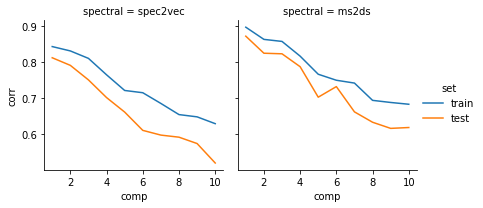

In [374]:
import seaborn as sns
def plot_canonical_comps(comps1, comps2, labels, latent_dims):
    """'comps' stands for the cca 'components'
    """
    # Prepare dataframe for plotting
    comps1['spectral'] = labels[0]
    comps2['spectral'] = labels[1]
    comps_df = pd.concat([comps1, comps2])
    comps_df['set'] = comps_df.index  # set new column equal to the indices
    comps_df_m = comps_df.melt(id_vars=['spectral','set'], 
                               var_name='comp', value_name='corr')
    
    g = sns.FacetGrid(comps_df_m, col='spectral', hue='set')
    g.map(sns.lineplot, 'comp', 'corr')
    #g.set(xticks=np.arange(latent_dims)+1)  # otherwise doesn't show all ticks
    g.add_legend()
    
plot_canonical_comps(comps_spec2vec, comps_ms2ds, ['spec2vec', 'ms2ds'], latent_dims)

The first two dimensions of the combined embedding latent space is plotted. The top row contains dimension 1 and dimension 2 respectively, with Spec2Vec on the x-axis and Mol2Vec on the y-axis. The bottom row first shows dimension 1 from the transformed Spec2Vec embedding on the x-axis and dimension 2 on the y-axis, and then the same for Mol2Vec.



In [375]:
def plot_latent(df):
    df_m = df.melt(value_vars=['X', 'Y'])
    df_m['value'].apply(pd.Series)
    #print(df)
    #print(df_m)
    #g = sns.FacetGrid(df_m, row='type', hue='variable', aspect=4, height=1.5, palette='Set2')
    #g.map(sns.kdeplot, 'dist', bw_adjust=0.7, shade=True, alpha=0.3)
    #g.add_legend()
    #g.set(ylabel=None, yticklabels=[])
    
plot_latent(df_spec2vec)

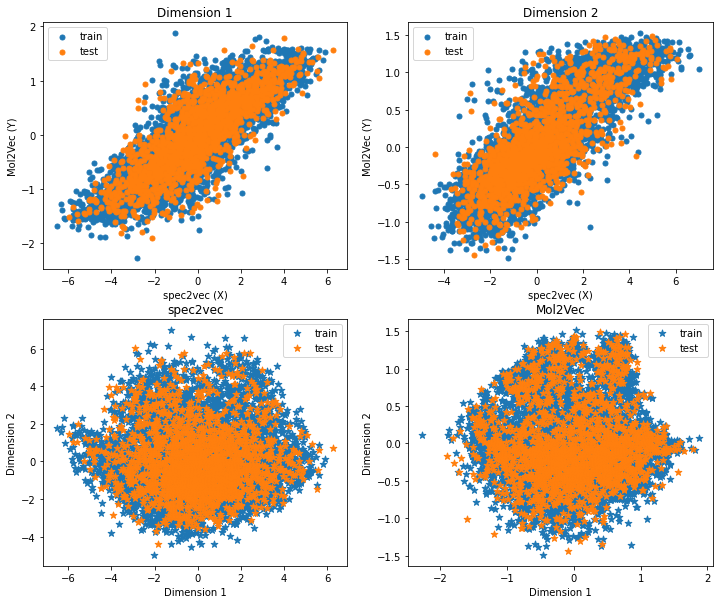

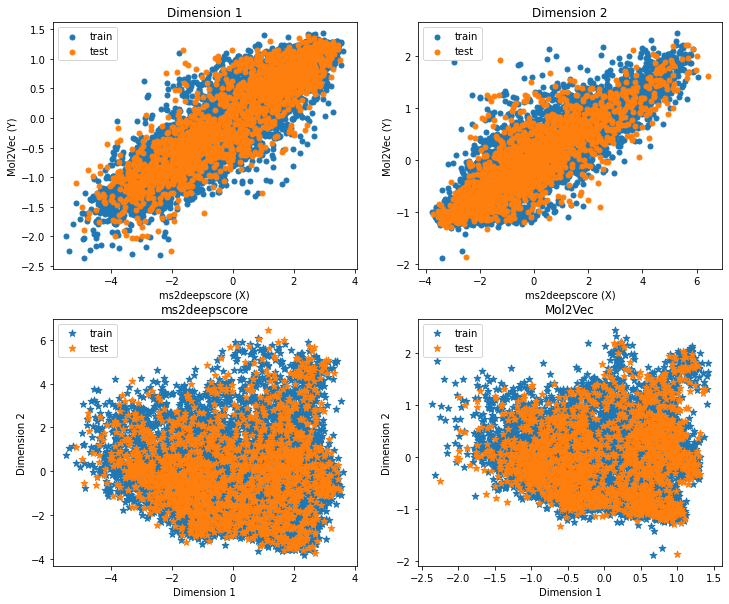

In [376]:
def plot_latent_space(trainX_latent, testX_latent, trainY_latent, testY_latent, spectral):
    """
    """
    plt.figure(figsize=(12, 10))
    plt.subplot(221)
    plt.scatter(trainX_latent[:, 0], trainY_latent[:, 0], label="train",
                marker="o", s=25)
    plt.scatter(testX_latent[:, 0], testY_latent[:, 0], label="test",
                marker="o", s=25)
    plt.xlabel("%s (X)" % spectral)
    plt.ylabel("Mol2Vec (Y)")
    plt.title('Dimension 1')
    plt.legend(loc="best")

    plt.subplot(222)
    plt.scatter(trainX_latent[:, 1], trainY_latent[:, 1], label="train",
                marker="o", s=25)
    plt.scatter(testX_latent[:, 1], testY_latent[:, 1], label="test",
                marker="o", s=25)
    plt.xlabel("%s (X)" % spectral)
    plt.ylabel("Mol2Vec (Y)")
    plt.title('Dimension 2')
    plt.legend(loc="best")

    plt.subplot(223)
    plt.scatter(trainX_latent[:, 0], trainX_latent[:, 1], label="train",
                marker="*", s=50)
    plt.scatter(testX_latent[:, 0], testX_latent[:, 1], label="test",
                marker="*", s=50)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title('%s' % spectral)
    plt.legend(loc="best")

    plt.subplot(224)
    plt.scatter(trainY_latent[:, 0], trainY_latent[:, 1], label="train",
                marker="*", s=50)
    plt.scatter(testY_latent[:, 0], testY_latent[:, 1], label="test",
                marker="*", s=50)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.title('Mol2Vec')
    plt.legend(loc="best")
    
    plt.show()
    
plot_latent_space(*latent_spec2vec, 'spec2vec')
plot_latent_space(*latent_ms2ds, 'ms2deepscore')

## 4. Assess latent space

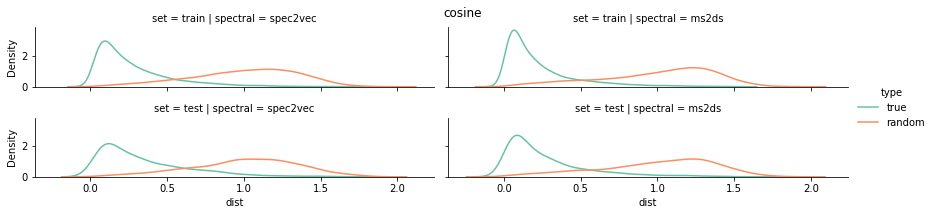

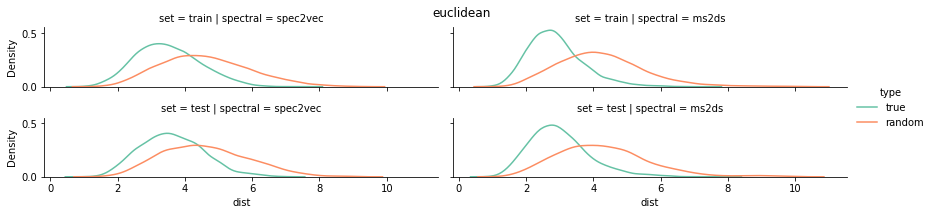

In [416]:
from scipy.spatial import distance

def get_dist_per_metric(df, metric):
    """
    """
    dist_list = []
    rand_list = []
    for i, row in df.iterrows():  
        # Get samples
        x = row['X']
        y = row['Y']
        
        # Also get distance between X and random Y point
        rand_y = df.sample()['Y'].values[0]

        # Get distance between X and Y in latent space, and append to list
        if metric == 'cosine':
            dist_list.append(distance.cosine(x, y))
            rand_list.append(distance.cosine(x, rand_y))
        elif metric == 'euclidean':
            dist_list.append(distance.euclidean(x, y))
            rand_list.append(distance.euclidean(x, rand_y))
        else:
            exit(1)
    
    # Turn distance lists into dataframes
    dist_df = pd.DataFrame(np.c_[dist_list, rand_list, df['set'], df['cf_class']],
                           columns=['true', 'random', 'set', 'cf_class'])
    
    return dist_df

def plot_dist(df1, name1, df2, name2, metric='cosine'):
    dist_df1 = get_dist_per_metric(df1, metric)
    dist_df1['spectral'] = name1
    dist_df2 = get_dist_per_metric(df2, metric)
    dist_df2['spectral'] = name2
    
    dist_df = pd.concat([dist_df1, dist_df2])
    
    dist_df_m = dist_df.melt(id_vars=['set', 'cf_class', 'spectral'], value_name='dist', var_name='type')
    
    g = sns.FacetGrid(dist_df_m, row='set', col='spectral', hue='type', aspect=4, height=1.5, palette='Set2')
    g.map(sns.kdeplot, 'dist')
    g.fig.suptitle('%s' % metric)
    g.add_legend()
    
plot_dist(df_spec2vec, "spec2vec", df_ms2ds, "ms2ds", "cosine")
plot_dist(df_spec2vec, "spec2vec", df_ms2ds, "ms2ds", "euclidean")